In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/subfolder/Global_local

/content/drive/MyDrive/subfolder/Global_local


In [ ]:
import os
import numpy as np
import pickle
import torch
from torch.optim import Adam
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import time
import h5py
import imutils
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision
from torch.optim import lr_scheduler
# from misc_functions import preprocess_image, recreate_image, save_image

In [ ]:
# read pickle file
with open('Customized_Gratings/Small_Gratings.pkl','rb') as f:
  gratings = pickle.load(f)

In [ ]:
cls = 9
times = 10
#train index
num = len(gratings)
div = 180/cls
index_tmp = np.repeat(np.arange(num),cls*cls)
k = []
for i in range(cls):
  k.extend([i*div])
k = k*num*cls
l = []
for i in range(cls):
  l.extend([i*div])
l = l*num
l = np.repeat(l,cls)
data_index = [i for i in zip(index_tmp,k,l)] 

In [ ]:
## grating based on requirements specified in index

class myDataset():
    """
    Args:
              input input_file_list = [f_content, f_angle]
              target_file_list = f_trans      
              patch_size: int , the cubic patch parameter     
    """
    def __init__(self,input_patches,index,cls = cls, input_size=224,random = False):

        self.index = index
        self.inputs = input_patches
        self.input_size = input_size
        self.div = 180/cls
       
    def __len__(self):
        return len(self.index)

    @staticmethod
    def rotate(img,angle):
        return imutils.rotate(img, angle=angle)

    @staticmethod
    ##Randomly distributed with minimum distance
    def random_distributed_with_minimum(n_points,half_distance,boundary_length):
      position = []
      occupied_length = 0
      remain_length = boundary_length 
      def set_first_remain_point(remain_n,remain_length):
          return random.randint(half_distance, remain_length - remain_n * half_distance *2 - half_distance) + occupied_length
      for i in range(n_points,0,-1):
          remain_n = i - 1
          p = set_first_remain_point(remain_n,remain_length)
          occupied_length = p + half_distance
          remain_length = boundary_length - occupied_length
          position.append(p)
      sign = random.randint(0,1)
      if sign:
        position =[(boundary_length - i) for i in position]
      return position
    def __getitem__(self, item):
        global p,img_0,n,img0,a
        idx, angle_l, angle_g = self.index[item]  
        if item == 0 or self.index[item-1][0] != self.index[item][0]:
            img_0 = self.inputs[idx]
            #uniform with random shading
            img_0 = img_0/255*random.uniform(0.5,1)
            a = img_0.shape[1]  #half of the patch's side length
            #num of gratings & generate random distributed positions
            n = 2 if self.input_size//a == 2 else random.randint(2,self.input_size//a)
            p = self.random_distributed_with_minimum(n,np.int(a//2),self.input_size)
            #Initialize with Gaussian noise
            noise_sigma = random.uniform(0,0.3)
            img0 = np.random.randn(3,self.input_size,self.input_size) * noise_sigma
        
        #random rotate locally 
        img = self.rotate(img_0.swapaxes(0,2),angle_l-angle_g).swapaxes(0,2)

        img_1 = np.zeros((3,self.input_size,self.input_size))
        img_out = img0.copy()
        #merge based on random distributed positions
        for i in p:
          # print(int(a//2),i,'\n')
          img_1[:,int(self.input_size//2-a//2):int(self.input_size//2+a//2),i-int(a//2):i+int(a//2)] += img

        #rotate globally based on label difference
        img_1 = self.rotate(img_1.swapaxes(0,2),angle_g).swapaxes(0,2)
        img_out += img_1
        img_out =  (img_out-np.min(img_out))/(np.max(img_out)-np.min(img_out))
        label_l = np.int(angle_l//self.div)
        label_g = np.int(angle_g//self.div)

        return torch.from_numpy(img_out).float(), label_l,label_g

In [ ]:
batch_size = 275

#set window length
dataset = myDataset(gratings,data_index)

In [ ]:
model = models.vgg16(pretrained=True).features

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# def normalize_output(img):
#     img = img - img.min()
#     img = img / img.max()
#     return img

# # Plot some images
# idx = torch.randint(0, output.size(0), ())
# pred = normalize_output(output[idx, 0])
# img = data[idx, 0]

# fig, axarr = plt.subplots(1, 2)
# axarr[0].imshow(img.detach().numpy())
# axarr[1].imshow(pred.detach().numpy())

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook



In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
model.eval().cuda()
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
sort = False 

In [ ]:
model.eval()
model.cuda()
model.layer4.register_forward_hook(get_activation('layer'))
output = model(data)
act = activation['layer'].squeeze().cpu()
print(act.shape)

torch.Size([512, 7, 7])


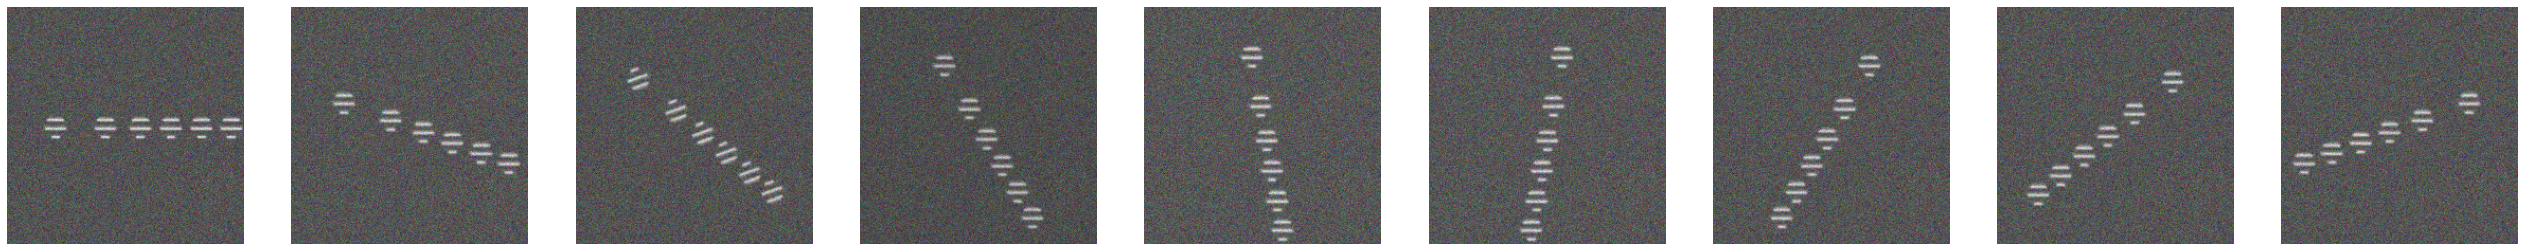

In [ ]:
img = []
img1 = []
idx = 810
fig = plt.figure(figsize = (5*cls,5))
ax = fig.subplots(1,cls)
for i in range(cls):
  id = i*9 + idx
  data, l, g = dataset[id]
  data.unsqueeze_(0)
  data = data.cuda()
  img.append(data)
  if i == 2:
    img1.append(data)
    for j in range(1,cls):
      id = i*9 + idx + j
      data, l, g = dataset[id]
      data.unsqueeze_(0)
      data = data.cuda()
      img1.append(data)
  
  ax[i].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i].axis('off')

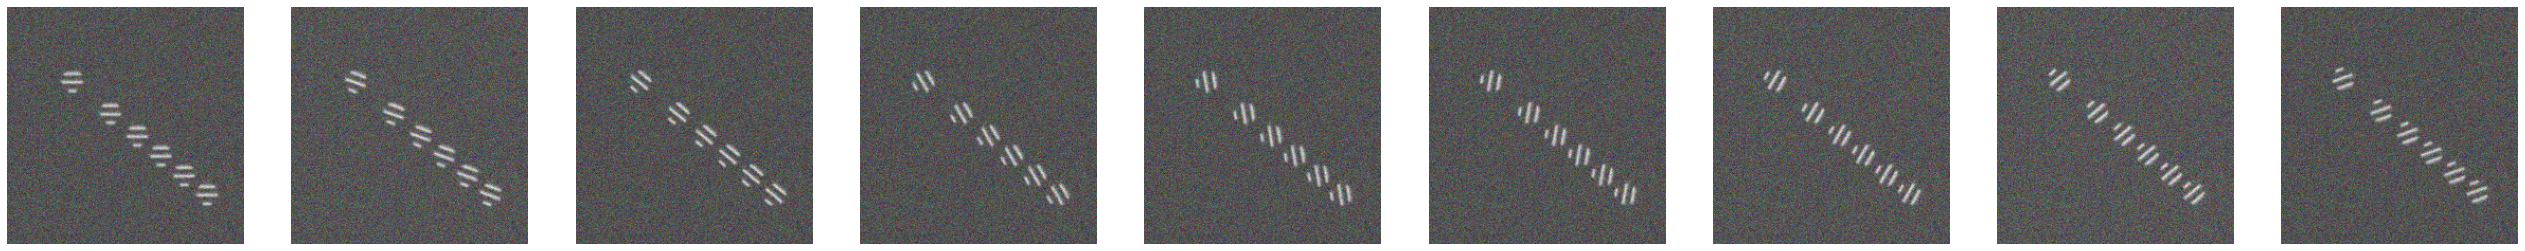

In [ ]:
fig = plt.figure(figsize = (5*cls,5))
ax = fig.subplots(1,cls)  
for i in range(cls):
  ax[i].imshow(img1[i][0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i].axis('off')

In [ ]:
img = img_tmp

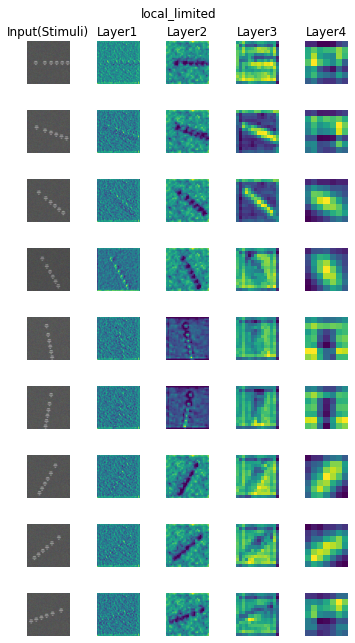

In [ ]:
im = []

t = 1 # No. x maximum
fig = plt.figure(figsize = (5,cls))
ax = fig.subplots(cls,5)
plt.suptitle('local_limited',y = 1)

cols = ['Input(Stimuli)','Layer1','Layer2','Layer3','Layer4']
for axes, col in zip(ax[0], cols):
    axes.set_title(col)
for i in range(9):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])

for i in range(cls):
  for j in range(4):
      ax[i,j+1].imshow(im[i*4+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 

In [ ]:
im = []
t = 1 # No. x maximum
k = 64 # k features shown
fig = plt.figure(figsize = (8/9*64,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 64 # k features shown
fig = plt.figure(figsize = (8/9*64,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()


im = []
t = 1 # No. x maximum
k = 128 # k features shown
fig = plt.figure(figsize = (8/9*128,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 128 # k features shown
fig = plt.figure(figsize = (8/9*128,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()


im = []
t = 1 # No. x maximum
k = 256 # k features shown
fig = plt.figure(figsize = (8/9*256,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 256 # k features shown
fig = plt.figure(figsize = (8/9*256,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()

im = []
t = 1 # No. x maximum
k = 512 # k features shown
fig = plt.figure(figsize = (8/9*512,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 512 # k features shown
fig = plt.figure(figsize = (8/9*512,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()

same global diff local

In [ ]:
img_tmp = img.copy()
img = img1

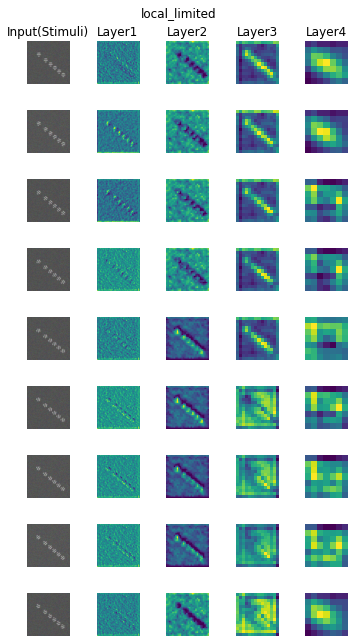

In [ ]:
im = []

t = 1 # No. x maximum
fig = plt.figure(figsize = (5,cls))
ax = fig.subplots(cls,5)
plt.suptitle('local_limited',y = 1)

cols = ['Input(Stimuli)','Layer1','Layer2','Layer3','Layer4']
for axes, col in zip(ax[0], cols):
    axes.set_title(col)
for i in range(9):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  im.append(act[-t,])

for i in range(cls):
  for j in range(4):
      ax[i,j+1].imshow(im[i*4+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 

In [ ]:
im = []
t = 1 # No. x maximum
k = 64 # k features shown
fig = plt.figure(figsize = (8/9*64,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 64 # k features shown
fig = plt.figure(figsize = (8/9*64,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer1.register_forward_hook(get_activation('layer1'))
  output = model(data)
  act = activation['layer1'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()


im = []
t = 1 # No. x maximum
k = 128 # k features shown
fig = plt.figure(figsize = (8/9*128,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 128 # k features shown
fig = plt.figure(figsize = (8/9*128,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer2.register_forward_hook(get_activation('layer2'))
  output = model(data)
  act = activation['layer2'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()


im = []
t = 1 # No. x maximum
k = 256 # k features shown
fig = plt.figure(figsize = (8/9*256,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 256 # k features shown
fig = plt.figure(figsize = (8/9*256,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer3.register_forward_hook(get_activation('layer3'))
  output = model(data)
  act = activation['layer3'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()

im = []
t = 1 # No. x maximum
k = 512 # k features shown
fig = plt.figure(figsize = (8/9*512,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  # act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Unsorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()
im = []
t = 1 # No. x maximum
k = 512 # k features shown
fig = plt.figure(figsize = (8/9*512,8))
ax = fig.subplots(cls,k + 1)
#plt.suptitle('local_limited',y = 1)

for i in range(cls):
  data = img[i]
  ax[i,0].imshow(data[0,].cpu().numpy().swapaxes(0,2).swapaxes(0,1))
  ax[i,0].axis('off')
  model = models.resnet18(pretrained=True)
  model.eval().cuda()
  # print('Row %d local orientation'%i,":",l)
  # print('       predicted local orientation',":",model(data).data.max(1)[1].cpu().numpy()[0])
  model.layer4.register_forward_hook(get_activation('layer4'))
  output = model(data)
  act = activation['layer4'].squeeze().cpu()
  act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
  if i == 0 : print('Sorted')
  for j in range(k):  
      im.append(act[-t-j,])


for i in range(cls):
  for j in range(k):
      ax[i,j+1].imshow(im[i*k+j])
      ax[i,j+1].axis('off')
plt.tight_layout() 
plt.show()
plt.close()

In [ ]:
how people preceive shape?
huamn has 3D vision 

instead of  cannot  should be would not because shape information is useless

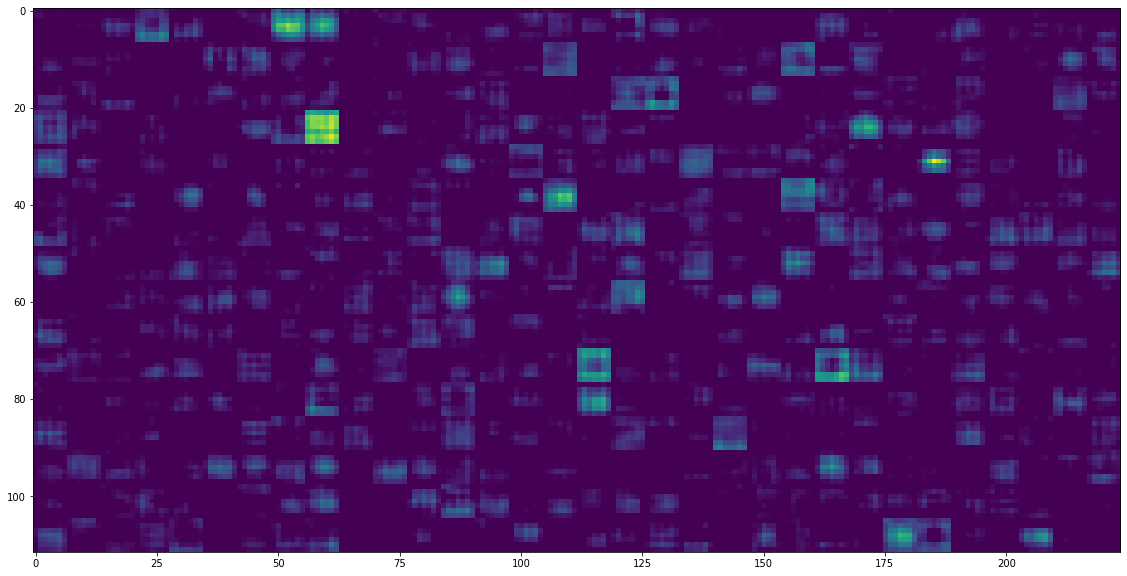

In [ ]:
x = 16
y = 32
if sort:
    act = act.numpy()[np.argsort(np.average(act.numpy().reshape(act.shape[0],-1),axis = 1)),]
im = []
for j in range(x):
   im.append(np.concatenate([act[i,] for i in range(j*y,(j+1)*y)],axis = 1))
im = np.concatenate(im,axis = 0)
plt.figure(figsize = (100,10))
plt.imshow(im)